In [1]:
import pandas as pd
import src.utils as utils
import os
from faker import Faker

from sklearn.model_selection import train_test_split

# Load config file

In [2]:
CONFIG_DATA = utils.config_load()
CONFIG_DATA

{'raw_dataset_path': 'data/raw',
 'data_set_path': 'data/output/data.pkl',
 'input_set_path': 'data/output/input.pkl',
 'output_set_path': 'data/output/output.pkl',
 'input_columns_path': 'data/output/input_columns.pkl',
 'train_set_path': ['data/output/X_train.pkl', 'data/output/y_train.pkl'],
 'valid_set_path': ['data/output/X_valid.pkl', 'data/output/y_valid.pkl'],
 'test_set_path': ['data/output/X_test.pkl', 'data/output/y_test.pkl'],
 'output_column': 'product_id',
 'seed': 42,
 'test_size': 0.2,
 'standardizer_path': 'data/output/standardizer.pkl',
 'preprocessor_path': 'data/output/preprocessor.pkl',
 'train_clean_path': ['data/output/X_train_clean.pkl',
  'data/output/y_train_clean.pkl'],
 'valid_clean_path': ['data/output/X_valid_clean.pkl',
  'data/output/y_valid_clean.pkl'],
 'test_clean_path': ['data/output/X_test_clean.pkl',
  'data/output/y_test_clean.pkl'],
 'list_of_model_path': 'log/list_of_model.pkl',
 'list_of_param_path': 'log/list_of_param.pkl',
 'list_of_tuned_mod

## Load Data

In [3]:
CONFIG_DATA['train_set_path'][0]

'data/output/X_train.pkl'

In [4]:
X_train = utils.pickle_load(CONFIG_DATA['train_set_path'][0])
y_train = utils.pickle_load(CONFIG_DATA['train_set_path'][1])

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (6196, 7)
y_train shape: (6196,)


In [5]:
data = pd.concat((X_train, y_train), axis=1)
data.head()

,customer_id,purchase_date,category,price,ratings,page_views,time_spent,product_id
3972,18,2024-04-25,Beauty,877,2.6,46,185,102
9322,6,2023-07-04,Clothing,180,2.1,25,213,102
8184,15,2023-07-02,Beauty,293,4.5,37,144,101
6385,3,2023-10-11,Electronics,732,4.9,14,138,103
9436,12,2023-06-15,Clothing,180,2.1,43,227,102


# EDA

cek data types

In [6]:
data.dtypes

customer_id        int64
purchase_date     object
category          object
price              int64
ratings          float64
page_views         int64
time_spent         int64
product_id         int64
dtype: object

In [7]:
# cek missing values
data.isna().sum()

customer_id      0
purchase_date    0
category         0
price            0
ratings          0
page_views       0
time_spent       0
product_id       0
dtype: int64

In [8]:
data.isna().sum().sum()

0

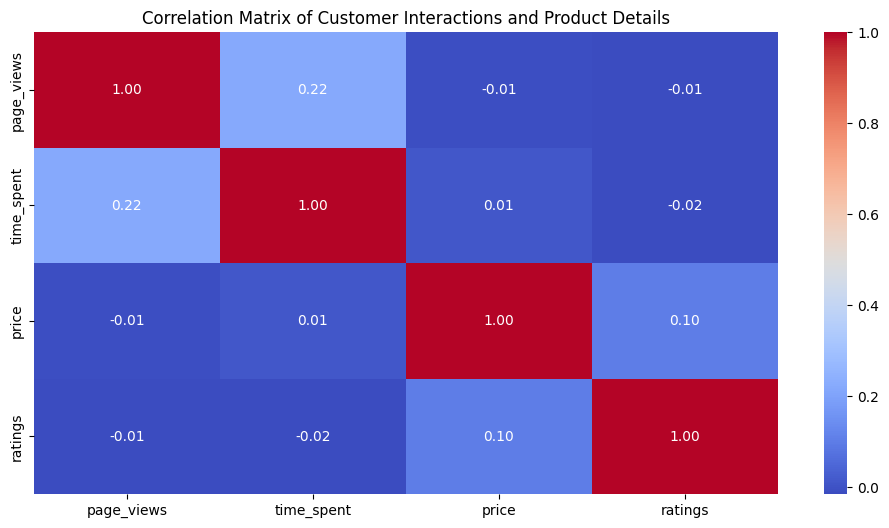

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Correlation matrix customer_interactions dan product_details
correlation_matrix = data[['page_views', 'time_spent', 'price', 'ratings']].corr()

# show heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Customer Interactions and Product Details')
plt.show()


- page_views dan time_spent: Ada korelasi positif, yang menunjukkan bahwa user yang melihat lebih banyak halaman cenderung menghabiskan lebih banyak waktu di situs. Hal ini menunjukkan bahwa konten yang menarik berpotensi meningkatkan waktu penelusuran.

- page_views dan price: Terdapat korelasi yang negatiif, yang menunjukkan bahwa variabel tersebut sangat lemah atau bahkan tidak ada hubungan linear yang signifikan di antara keduanya. Peningkatan atau penurunan jumlah page_views tidak berdampak secara konsisten pada price, dan sebaliknya.

- time_spent dan price: time_spent yang dihabiskan di situs menunjukkan korelasi yang lemah dengan harga produk yang dibeli.

- ratings: page_views dan spent_time korelasinya sangat lemah dengan ratings, yang mungkin menunjukkan bahwa keputusan user untuk melihat halaman atau spent_time tidak terlalu dipengaruhi oleh peringkat produk.

note: korelasi mendekati 1 menunjukkan korelasi positif. Korelasi mendekati -1 menunjukkan tidak adanya hubungan linear antara dua variabel.

### Cek produk kategori yang populer dan pola pembeliannya

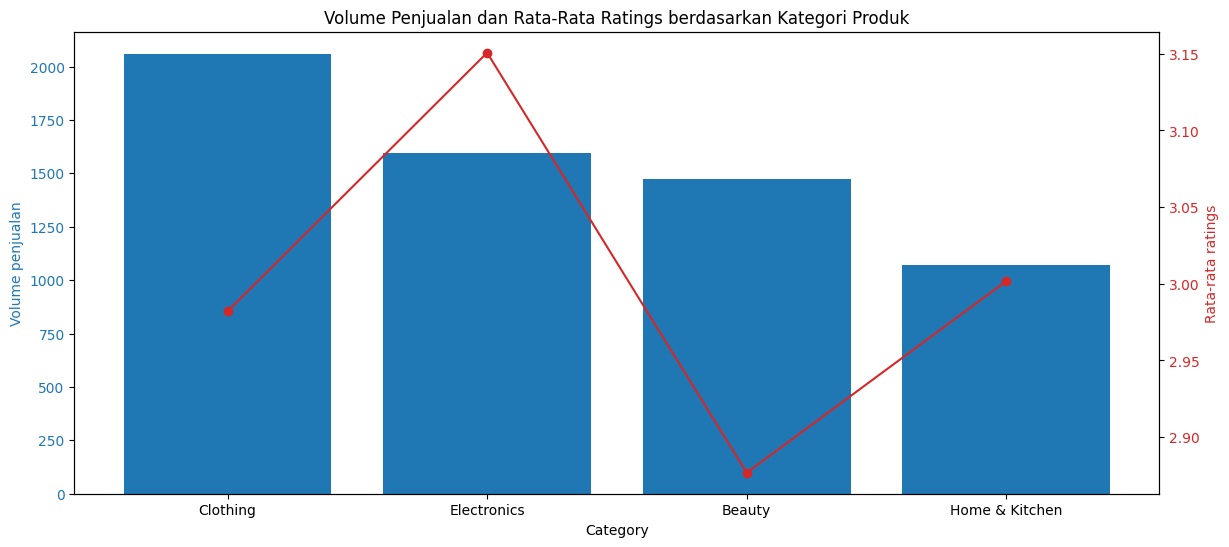

In [10]:
# Grouping data
category_analysis = data.groupby('category').agg(
    Sales_Volume=('product_id', 'count'),
    Average_Price=('price', 'mean'),
    Average_Ratings=('ratings', 'mean')
).sort_values(by='Sales_Volume', ascending=False)


fig, ax1 = plt.subplots(figsize=(14, 6))

# plot sales volume
color = 'tab:blue'
ax1.set_xlabel('Category')
ax1.set_ylabel('Volume penjualan', color=color)
ax1.bar(category_analysis.index, category_analysis['Sales_Volume'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# plot twin axis untuk rata2 ratings
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Rata-rata ratings', color=color)
ax2.plot(category_analysis.index, category_analysis['Average_Ratings'], color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Volume Penjualan dan Rata-Rata Ratings berdasarkan Kategori Produk')
plt.show()


In [11]:
data['ratings'].value_counts()

ratings
2.1    501
3.0    398
2.8    287
4.5    281
3.5    278
1.1    254
4.3    223
1.2    223
4.7    203
4.4    200
1.5    196
3.3    187
4.1    179
3.8    179
3.6    177
3.7    167
1.8    164
2.5    152
2.9    146
3.4    137
4.2    130
1.0    126
1.6    122
2.2    116
2.7    113
1.3    108
4.6    107
3.1    106
5.0     97
2.6     93
1.9     90
3.9     88
2.4     86
2.3     80
4.8     79
4.9     67
2.0     56
Name: count, dtype: int64

Karna ini pakai data dummy jadi seperti ada anomali, dimana kategori yang punya volume penjualan terbanyak malah memiliki rata2 rating paling kecil.
Pada real case nya rata2 rating mempengaruhi keputusan pembelian

**Insight**
1. Category performance: Kategori dengan penjualan lebih tinggi dan rating yang lebih baik mungkin diprioritaskan untuk keputusan dilakukan promosi. Sebaliknya, kategori dengan penjualan dan peringkat lebih rendah mungkin memerlukan penyesuaian pemasaran atau peningkatan kualitas produk.

2. Strategi pemasaran: Memahami kategori mana yang punya kinerja baik dalam hal penjualan dan kepuasan pelanggan busa membantu menyesuaikan strategi pemasaran.

### Tren Analysis

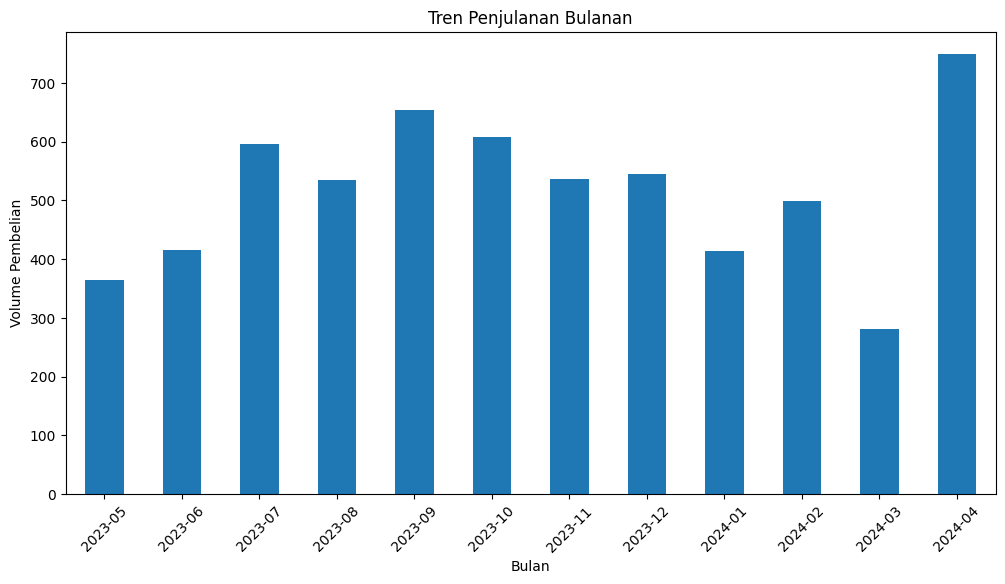

In [12]:
# convert 'purchase_date' jadi datetime dan untuk ekstrak bulan dan tahun
data['purchase_date'] = pd.to_datetime(data['purchase_date'])
data['year_month'] = data['purchase_date'].dt.to_period('M')

# Grouping berdasarkan bulan untuk menghitung penmbelian
monthly_sales = data.groupby('year_month').size()

# Plotting 
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='bar')
plt.title('Tren Penjulanan Bulanan')
plt.xlabel('Bulan')
plt.ylabel('Volume Pembelian')
plt.xticks(rotation=45)
plt.show()


selama 1 tahun, penujalan paling rendah ada di bulan maret 2024, dan paling tinggi di april 2024

### Product Performance analysis

In [13]:
# Asumsi kategori teratas berdasarkan data volume penjualan sebelumnya, mpakai 3 kategori teratas untuk analisis yang lebih detail
# identifikasi 3 kategori teratas
top_categories = category_analysis.index[:3]

# filter data untuk dari ketegori terats
top_category_data = data[data['category'].isin(top_categories)]

# Grouping data berdasarkan produk dalam kategori teratas untuk menganalisis volume penjualan, harga rata2, dan rata2 rating
product_performance = top_category_data.groupby(['category', 'product_id']).agg(
    Sales_Volume=('product_id', 'count'),
    Average_Price=('price', 'mean'),
    Average_Ratings=('ratings', 'mean')
).sort_values(by=['category', 'Sales_Volume'], ascending=False)

product_performance.reset_index().head(10)  # tampilkan top 10

,category,product_id,Sales_Volume,Average_Price,Average_Ratings
0,Electronics,102,455,432.648352,2.704396
1,Electronics,105,429,290.368298,3.070396
2,Electronics,101,297,389.282828,3.097643
3,Electronics,104,279,654.390681,3.319355
4,Electronics,103,133,702.721805,4.701504
5,Clothing,105,933,618.484459,2.989925
6,Clothing,102,332,567.496988,2.310843
7,Clothing,101,323,487.823529,3.191331
8,Clothing,104,277,562.606498,3.054513
9,Clothing,103,195,445.902564,3.637436


**INSIGHT**
1.  Penjualan Tertinggi dan Rating Tertinggi: Electronics 102 dan Electronics 103 menunjukkan kinerja yang baik berdasarkan volume penjualan yang tinggi dan tingkat kepuasan pelanggan.

2.   Sensitivitas Harga: Produk dengan harga lebih tinggi seperti Electronics 103 menunjukkan volume penjualan yang lebih rendah, menunjukkan sensitivitas harga dalam kategori ini.

3.   Rating: Clothing 105, ini penjualannya paling tinggi, tapi punya rating yang rendah, yang bisa menjadi area untuk perbaikan atau analisis feedback dari pelanggan.

**REKOMENDASI**
1. Strategi Penetapan Harga: Untuk barang dengan harga tinggi dengan penjualan lebih rendah, bisa dipertimbangkan untuk menyesuaikan harga atau meningkatkan kualitas dan fitur produk untuk meningkatkan rating dan kepuasan pelanggan.

2. Meningkatkan Kualitas Produk atau Layanan kepada Pelanggan: Untuk produk dengan rating yang rendah, teliti keluhan atau feedback dari pelanggan untuk meningkatkan kualitas produk.

3. Area Fokus Promosi: Produk yang berkinerja baik bisa dijadikan kampanye pemasaran untuk meningkatkan penjualan yang lebih masif.

## Data Processing
1. encode category:

In [14]:
def load_dataset(return_file=True):
    # Load train data
    X_train = utils.pickle_load(CONFIG_DATA['train_set_path'][0])
    y_train = utils.pickle_load(CONFIG_DATA['train_set_path'][1])

    # Load valid data
    X_valid = utils.pickle_load(CONFIG_DATA['valid_set_path'][0])
    y_valid = utils.pickle_load(CONFIG_DATA['valid_set_path'][1])

    # Load test data
    X_test = utils.pickle_load(CONFIG_DATA['test_set_path'][0])
    y_test = utils.pickle_load(CONFIG_DATA['test_set_path'][1])

    # Print 
    print("X_train shape :", X_train.shape)
    print("y_train shape :", y_train.shape)
    print("X_valid shape :", X_valid.shape)
    print("y_valid shape :", y_valid.shape)
    print("X_test shape  :", X_test.shape)
    print("y_test shape  :", y_test.shape)

    if return_file:
        return X_train, X_valid, X_test, y_train, y_valid, y_test

In [15]:
X_train, X_valid, X_test, y_train, y_valid, y_test = load_dataset()

X_train shape : (6196, 7)
y_train shape : (6196,)
X_valid shape : (1549, 7)
y_valid shape : (1549,)
X_test shape  : (1937, 7)
y_test shape  : (1937,)


## Preprocess train
scale the data

In [16]:
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
import pickle


def fit_standardize(data, columns=['page_views', 'time_spent', 'price', 'ratings'], return_file=True):
    standardizer = RobustScaler()

    # Fit standardizer on the provided columns
    standardizer.fit(data[columns])
    
    # Dump standardizer
    utils.pickle_dump(standardizer, CONFIG_DATA['standardizer_path'])
    
    if return_file:
        return standardizer

In [17]:
from sklearn.preprocessing import LabelEncoder

# enocde categoru and Fit standardizer
encoder = LabelEncoder()
X_train['category_encoded'] = encoder.fit_transform(X_train['category'])
X_test['category_encoded'] = encoder.fit_transform(X_test['category'])
X_train.drop(columns=['category', 'purchase_date'], inplace=True) 
X_test.drop(columns=['category', 'purchase_date'], inplace=True)

standardizer = fit_standardize(data=X_train)

In [18]:
X_train

,customer_id,price,ratings,page_views,time_spent,category_encoded
3972,18,877,2.6,46,185,0
9322,6,180,2.1,25,213,1
8184,15,293,4.5,37,144,0
6385,3,732,4.9,14,138,2
9436,12,180,2.1,43,227,1
...,...,...,...,...,...,...
3727,8,314,3.9,13,140,0
4182,10,720,4.4,12,153,2
4003,18,920,1.8,43,85,1
5450,15,673,4.5,13,194,2


In [19]:
X_train['customer_id'].value_counts()

customer_id
15    777
3     612
6     522
5     463
9     437
18    400
8     372
20    371
10    346
11    328
16    328
7     316
12    204
14    180
17    170
4     135
19     86
2      76
13     57
1      16
Name: count, dtype: int64

In [20]:
X_test

,price,ratings,page_views,time_spent,category_encoded
3204,426,4.5,48,167,2
2094,266,1.6,18,106,0
2698,673,4.5,4,62,2
6071,207,2.8,11,35,1
346,81,1.5,17,62,3
...,...,...,...,...,...
5944,396,3.5,14,249,2
1794,979,3.6,32,260,1
3595,706,1.6,22,69,1
2473,877,2.8,44,110,3


In [22]:
X_train.describe()

,price,ratings,page_views,time_spent,category_encoded
count,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000
mean,500.219496,3.003793,24.908974,169.329890,1.364751
std,265.035230,1.147331,13.700384,75.011626,1.026026
min,20.000000,1.000000,2.000000,31.000000,0.000000
25%,276.000000,2.100000,14.000000,106.000000,1.000000
50%,491.000000,3.000000,23.000000,170.000000,1.000000
75%,723.000000,4.100000,38.000000,231.000000,2.000000
max,979.000000,5.000000,50.000000,300.000000,3.000000


In [23]:
X_test.describe()

,price,ratings,page_views,time_spent,category_encoded
count,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000
mean,514.950955,3.041353,25.304595,170.481673,1.342282
std,262.619434,1.144493,13.904528,74.064020,0.998467
min,20.000000,1.000000,2.000000,31.000000,0.000000
25%,285.000000,2.100000,14.000000,106.000000,1.000000
50%,554.000000,3.000000,24.000000,183.000000,1.000000
75%,730.000000,4.100000,39.000000,229.000000,2.000000
max,979.000000,5.000000,50.000000,300.000000,3.000000


In [25]:
y_train.value_counts(normalize=True)

product_id
105    0.305197
102    0.244674
104    0.168496
103    0.150581
101    0.131052
Name: proportion, dtype: float64

In [27]:
X_test.columns.tolist()

['price', 'ratings', 'page_views', 'time_spent', 'category_encoded']